In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
ls

CreateDataset.ipynb    MobileNetV2+SSD_v1.ipynb  MobileNetV2+SSD_v4.ipynb
data/                  MobileNetV2+SSD_v2.ipynb  TestKeras.ipynb
MobileNetV2+SSD.ipynb  MobileNetV2+SSD_v3.ipynb


In [48]:
import tensorflow as tf
import numpy as np
from numpy import matlib
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras import backend as K

In [49]:
IMG_SIZE = 224
NUM_CLASSES = 10

layerWidths = [28,14,7,4,2,1]
numBoxes = [3,3,3,3,3,3]
assert len(numBoxes) == len(layerWidths)        # numBoxes for each layer and each layer has a specific width
outputChannels = NUM_CLASSES + 1 + 4            # 10 classes + background + cx,cy,h,w
assert outputChannels - NUM_CLASSES == 5

Reference is taken from this blog. https://d2l.ai/chapter_computer-vision/anchor.html \\
"*Assume that the input image has a height of h and width of w. We generate anchor boxes with different shapes centered on each pixel of the image. Assume the size is s∈(0,1], the aspect ratio is r>0, and the width and height of the anchor box are ws√r and hs/√r, respectively. When the center position is given, an anchor box with known width and height is determined.*" \\

s: scale, h: grid_size, w: grid_size and r: asp

In [50]:
def create_default_boxes():
	# number of scales is equal to the number of different resolutions ie num of layer widths
	# for a given resolution, we have different aspect ratios
	# num(scales) = num(layerWidth) = num(numBoxes) and num(asp_ratios) = numBoxes[i]
	MinScale = .1 					# Min and Max scale given as percentage
	MaxScale = 1.5
	scales = [ MinScale + x/len(layerWidths) * (MaxScale-MinScale) for x in range(len(layerWidths))]
	scales = scales[::-1] 						# reversing the order because the layer_widths go from high to low (lower to higher resoltuion)

	asp = [0.5,1.0,1.5]
	asp1 = [x**0.5 for x in asp]
	asp2 = [1/x for x in asp1]

	# Should be equal to the output of the MobileNetV2-SSD model.
	TOTAL_BOXES = sum([a*a*b for a,b in zip(layerWidths, numBoxes)])		# Computes total number of boxes. (Sum of (layer_widths*layer_widths*num_boxes))

	centres = np.zeros((TOTAL_BOXES,2))
	hw = np.zeros((TOTAL_BOXES,2))
	boxes = np.zeros((TOTAL_BOXES,4))

	# Calculating the default boxes (centres, height, width)
	idx = 0
	for grid_size, num_box, scale in zip(layerWidths, numBoxes, scales):
		step_size = IMG_SIZE*1.0/grid_size
		for i in range(grid_size):
			for j in range(grid_size):
				pos = idx + (i*grid_size+j) * num_box
				# centre is the same for all aspect ratios(=num_box)
				centres[ pos : pos + num_box , :] = i*step_size + step_size/2, j*step_size + step_size/2
				# height and width vary according to the scale and aspect ratio
				hw[ pos : pos + num_box , :] = np.multiply(grid_size*scale, np.squeeze(np.dstack([asp1, asp2]),axis=0))[:num_box,:]

		idx += grid_size*grid_size*num_box


	# (x,y) co-ordinates of top left and bottom right
	# This actually is not used anywhere. centres[] and hw[] are a good enough substitute
	boxes[:,0] = centres[:,0] - hw[:,0]/2
	boxes[:,1] = centres[:,1] - hw[:,1]/2
	boxes[:,2] = centres[:,0] + hw[:,0]/2
	boxes[:,3] = centres[:,1] + hw[:,1]/2

	return boxes, TOTAL_BOXES, centres, hw

In [51]:
boxes, TOTAL_BOXES, centres, hw = create_default_boxes()

In [52]:
# calculate IoU for a set of search boxes and default boxes
def IoU(box1, box2):
	box1 = box1.astype(np.float64)
	box2 = box2.astype(np.float64)

	x_top_left = np.maximum(box1[:,0], box2[:,0])			# find x-coordinate of top-left corner for intersection.
	x_bottom_right = np.minimum(box1[:,2], box2[:,2])			# find x-cordinate of bottom-right corner for intersection.
	y_top_left = np.maximum(box1[:,1], box2[:,1])			# find y-coordinate of top-left corner for intersection.
	y_bottom_right = np.minimum(box1[:,3], box2[:,3])			# find y-coordinate of bottom-right corner for intersection.

	intersection = np.abs(np.maximum(x_bottom_right - x_top_left,0) * np.maximum(y_bottom_right - y_top_left,0))
	
	boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
	boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
	
	unionArea = boxArea1 + boxArea2 - intersection
	assert (unionArea > 0).all()
	return intersection / unionArea

In [53]:
# give the index of the box correpsonding to the IoUs > threshold (=0.5) 
def bestIoU(searchBox):
    return np.argwhere(IoU(matlib.repmat(searchBox, TOTAL_BOXES, 1), boxes) > 0.5)

In [54]:
classes = 15    # 10 classes + 1 background + 4 locations
base_model=tf.keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)        # Use of MobileNetV2 as a backbone for SSD.

feature0 = base_model.get_layer('block_6_expand_relu').output
feature1 = base_model.get_layer('block_13_expand_relu').output

featureMaps = 6
features = [None for _ in range(featureMaps)]
classifiers = [None for _ in range(featureMaps)]

conv1_1 = tf.keras.layers.Conv2D(256,1,name='SSD_conv_1_1')
conv1_2 = tf.keras.layers.Conv2D(512,3,strides=(2,2),padding='same',name='SSD_conv_1_2')

conv2_1 = tf.keras.layers.Conv2D(128,1,name='SSD_conv_2_1')
conv2_2 = tf.keras.layers.Conv2D(256,3,strides=(2,2),padding='same',name='SSD_conv_2_2')

conv3_1 = tf.keras.layers.Conv2D(128,1,name='SSD_conv_3_1')
conv3_2 = tf.keras.layers.Conv2D(256,3,strides=(1,1),name='SSD_conv_3_2')

conv4_1 = tf.keras.layers.Conv2D(128,1,name='SSD_conv_4_1')
conv4_2 = tf.keras.layers.Conv2D(256,2,strides=(1,1),name='SSD_conv_4_2') # changed the kernel size to 2 since the output of the previous layer has width 3

conv = []
reshape = []

for i in range(featureMaps):
    conv.append(tf.keras.layers.Conv2D(numBoxes[i]*outputChannels, 3, padding='same', name='Classification_'+str(i)))
    reshape.append(tf.keras.layers.Reshape((layerWidths[i]* layerWidths[i] * numBoxes[i], outputChannels),name='Reshape_classification_'+str(i)))

# Use of different spatial features.
features[0] = feature0
features[1] = feature1
features[2] = conv1_2(conv1_1(features[1]))
features[3] = conv2_2(conv2_1(features[2]))
features[4] = conv3_2(conv3_1(features[3]))
features[5] = conv4_2(conv4_1(features[4]))

for i in range(featureMaps):
    x = conv[i](features[i])            # Apply 1x1 convolutions to generate bounding boxes.
    x = reshape[i](x)                   # Reshape the output to (batch_size x TOTAL_BOXES x classes)
    classifiers[i] = x
output = tf.keras.layers.concatenate(classifiers, axis = -2, name='concatenate')

model=tf.keras.Model(inputs=base_model.input,outputs=output) #specify the inputs and outputs
# model.summary()

Following functions are used to access the dataset from tfrecords. (Used https://dzlab.github.io/dltips/en/tensorflow/tfrecord/ as a reference.)

In [55]:
def _parse_function(proto):
	# define your tfrecord again. Remember that you saved your image as a string.
	keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
						'label': tf.io.FixedLenFeature([], tf.string)}
	
	# Load one example
	parsed_features = tf.io.parse_single_example(proto, keys_to_features)
	
	# Turn your saved image string into an array
	parsed_features['image'] = tf.io.decode_raw(parsed_features['image'], tf.float64)
	parsed_features['image'] = tf.reshape(parsed_features['image'], (224, 224, 3))
	parsed_features['label'] = tf.io.decode_raw(parsed_features['label'], tf.float64)
	parsed_features['label'] = tf.reshape(parsed_features['label'], (3150, 5))

	return parsed_features['image'], parsed_features['label']

  
def create_dataset(filepath):
	
	# This works with arrays as well
	dataset = tf.data.TFRecordDataset(filepath)
	
	# Maps the parser on every filepath in the array. You can set the number of parallel loaders here
	dataset = dataset.map(_parse_function, num_parallel_calls=8)
	return dataset

In [56]:
train_dataset = create_dataset(['data/mnist_obj_detection_2000_train.tfrecords'])
test_dataset = create_dataset(['data/mnist_obj_detection_100_test.tfrecords'])

In [57]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 60

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)
print(train_dataset)
print(test_dataset)

<BatchDataset shapes: ((10, 224, 224, 3), (10, 3150, 5)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((10, 224, 224, 3), (10, 3150, 5)), types: (tf.float64, tf.float64)>


Smooth L1 loss function's code is based on the function given at https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html 

In [58]:
# calculate the smooth L1 loss
def smoothL1(x,y):
    diff = K.abs(x-y)
    result = K.switch(diff < 1, 0.5 * diff**2, diff - 0.5)
    return K.mean(result)

Below function for hard negative mining is referred from this repository
https://github.com/ChunML/ssd-tf2/blob/master/losses.py

In [59]:
# This is the old code for negative hard mining.
# def hard_negative_mining(loss, gt_confs, neg_ratio=3):
#     pos_idx = gt_confs < 10
#     num_pos = tf.reduce_sum(tf.dtypes.cast(pos_idx, tf.int32), axis=1)
#     num_neg = num_pos * neg_ratio

#     rank = tf.argsort(loss, axis=1, direction='DESCENDING')
#     rank = tf.argsort(rank, axis=1)
#     neg_idx = rank < tf.expand_dims(num_neg, 1)

#     return pos_idx, neg_idx

# def confidenceLoss(y, label):
#     classification_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(label, y)
#     pos_idx, neg_idx = hard_negative_mining(classification_loss, label)
#     cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#     classification_loss = cross_entropy(label[tf.math.logical_or(pos_idx, neg_idx)], y[tf.math.logical_or(pos_idx, neg_idx)])
#     return K.mean(classification_loss)

The following loss function is written based on the information given in this blog (https://becominghuman.ai/tensorflow-object-detection-api-basics-of-detection-7b134d689c75)

In [60]:
# Contains implementation of Hard Negative Mining.
def confidenceLoss(y, label):
    total_classification_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(label, y)

    positive_indices = label < 10                                           # Find boxes having mnist digits.
    positive_classification_loss = tf.math.reduce_mean(total_classification_loss[positive_indices])

    negative_indices = 1.0 - tf.cast(positive_indices, tf.float32)                                 # Find boxes having no mnist digits.
    negative_classification_loss = total_classification_loss*negative_indices                      # Make loss of all postive boxes as zero.
    negative_classification_loss = tf.sort(negative_classification_loss, axis=1, direction='DESCENDING')
    
    positive_indices = tf.cast(positive_indices, tf.int32)                  # Cast the boolean tensor to integers.
    total_num_positives = tf.math.reduce_sum(positive_indices, axis=1)      # Find the total number of boxes containing mnist digits.
    required_num_negatives = tf.cast(3*total_num_positives, tf.int32)       # Usual ratio of negative examples to positive examples is 3:1. (This will give value of k to choose top-k negative losses.)
    
    batch_size, number_images = negative_classification_loss.shape          # Find batch size and number of image.
    array = tf.constant(np.array([np.arange(number_images) for _ in range(batch_size)]))        # Create an array to select top-k negative losses.
    array = tf.cast(array, tf.int32)
    negative_indices = array < tf.expand_dims(required_num_negatives, axis=1)                               # Make True for top-k elements and the rest to be False.
    negative_classification_loss = tf.math.reduce_mean(negative_classification_loss[negative_indices])       # Compute negative loss using top-k elements.

    return tf.math.reduce_mean([positive_classification_loss, negative_classification_loss])

In [61]:
def Loss(gt, y):
    # shape of y is batch_size * BOXES * outputChannels
    # shape of gt is batch_size * BOXES * 5 
    loss = 0
    # localisation loss
    loss += smoothL1(y[:,:,-4:], gt[:,:,-4:])
    # confidence loss
    loss += confidenceLoss(y[:,:,:-4], tf.cast(gt[:,:,0],tf.int32))
    return loss

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),loss=Loss)

In [63]:
history = model.fit(train_dataset, epochs=20, validation_data = test_dataset)

Epoch 1/20
200/200 [==============================] - 26s 97ms/step - loss: 2.8193 - val_loss: 1.5974
Epoch 2/20
200/200 [==============================] - 19s 93ms/step - loss: 1.2201 - val_loss: 1.3494
Epoch 3/20
200/200 [==============================] - 19s 93ms/step - loss: 0.9411 - val_loss: 1.2667
Epoch 4/20
200/200 [==============================] - 19s 92ms/step - loss: 0.7933 - val_loss: 1.1250
Epoch 5/20
200/200 [==============================] - 19s 93ms/step - loss: 0.7008 - val_loss: 0.9922
Epoch 6/20
200/200 [==============================] - 19s 93ms/step - loss: 0.6398 - val_loss: 0.9441
Epoch 7/20
200/200 [==============================] - 19s 92ms/step - loss: 0.5918 - val_loss: 0.9066
Epoch 8/20
200/200 [==============================] - 19s 92ms/step - loss: 0.5527 - val_loss: 0.8110
Epoch 9/20
200/200 [==============================] - 19s 93ms/step - loss: 0.5263 - val_loss: 0.7369
Epoch 10/20
200/200 [==============================] - 19s 93ms/step - loss: 0.497

In [64]:
# get prediction for one sample
iterator = tf.compat.v1.data.make_one_shot_iterator(test_dataset)
image, label = iterator.next()
y_pred = model.predict(image)
y_pred.shape

(10, 3150, 15)

Below visulization codes are referred from other repository.

In [65]:
import bottleneck
OBJperCLASS = 10 # get the top 10 results for each class
# get the confidence scores (with class values) and delta for the boxes. For each class, the top 10 values are used
def infer(Y):
    # classes are actually the index into the default boxes
    classes = np.zeros((OBJperCLASS, outputChannels-4), dtype=np.uint16)        # [10, 11]
    conf = np.zeros((OBJperCLASS, outputChannels-4))                            # [10, 11]
    delta = np.zeros((OBJperCLASS, outputChannels-4, 4))                        # [10, 11, 4]
    class_predictions = softmax(Y[:,:outputChannels-4],axis=1)                  # [3150, 11]
    for i in range(outputChannels-4):                                           # (Loop to find boxes for each mnist digit class)
        # Basically the below line is used to find 11 boxes for the present mnist digit.
        classes[:,i] = bottleneck.argpartition(class_predictions[:,i], TOTAL_BOXES-1-10 , axis=-1)[-OBJperCLASS:]      # It will take class_prediction[:, i] (sized 3150,1) and argpartition at the 3150-11th element from last.
        conf[:,i] = class_predictions[classes[:,i],i]               # Confidence score for each digit.
        delta[:,i] = Y[classes[:,i],outputChannels-4:]              # Used to find cx, cy, h, w.
    return conf, classes, delta

# generate bounding boxes from the inferred outputs
def Bbox(confidence,box_idx,delta):
    #delta contains delta(cx,cy,h,w)
    bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
    bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
    for i in range(OBJperCLASS):
        bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
        bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
        bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
        bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]
    return bbox_centre,bbox_hw

1
1: Confidence-0.7192611694335938		Centre-[133.94481742 173.45008862] Height,Width-[44.48038623 44.38547942]
1: Confidence-0.7321313619613647		Centre-[145.78119493 180.25489563] Height,Width-[30.22330516 49.00654077]
1: Confidence-0.7364127039909363		Centre-[146.09604633 180.00329108] Height,Width-[40.69682261 40.27306267]
1: Confidence-0.7331182360649109		Centre-[140.29965976 186.49011993] Height,Width-[44.82474217 33.86878242]
1: Confidence-0.8591009974479675		Centre-[133.02950478 174.16802812] Height,Width-[45.14272162 40.66705217]
1: Confidence-0.9407851696014404		Centre-[139.49104172 185.90445304] Height,Width-[38.71506902 39.2043595 ]
1: Confidence-0.9467900395393372		Centre-[139.36976701 178.49921417] Height,Width-[44.64108023 40.39098825]
1: Confidence-0.9552264213562012		Centre-[138.36097181 177.84572363] Height,Width-[45.32551524 44.85514113]
1: Confidence-0.9760034084320068		Centre-[139.49357289 174.66210985] Height,Width-[45.13726756 39.2723855 ]
1: Confidence-0.9136365056

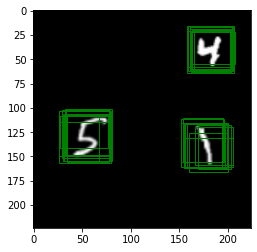

In [67]:
idx = np.random.randint(BATCH_SIZE)
from scipy.special import softmax

# top 10 predictions for each class
confidence, box_idx, delta = infer(y_pred[idx])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

im = np.array(Image.fromarray(image[idx].numpy().astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
  # skipping backgrounds
    if i == NUM_CLASSES:
        continue
    color = 'r'
    # if a class is mentioned in the ground truth, color the boxes green
    if i in label[idx,:,0]:
        color = 'g'
        print(i)
    
    # skip all the classes which have low confidence values
    if (confidence[:,i] > 0.5).any() or i in label[idx,:,0]:
        for k in range(OBJperCLASS):
            print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
      
            # draw bounding box only if confidence scores are high
            if confidence[k,i] < 0.5:
                continue
            x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
            y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
            rect = patches.Rectangle((y,x),bbox_hw[k,i,1],bbox_hw[k,i,0],linewidth=1,edgecolor=color,facecolor='none')
            ax.add_patch(rect)

plt.show()